In [ ]:
# Split up the dataset randomly into 80% train set, 10% dev set, 10% test set.
# Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
import random # shuffle the list of words to get an even distribution

words = open('../names.txt', 'r').read().splitlines()
random.seed(230)
random.shuffle(words)
train_set = words[:int(len(words)*0.8)]
dev_set = words[int(len(words)*0.8):int(len(words)*0.9)]
test_set = words[int(len(words)*0.9):]


In [ ]:
# Map the words to indexes
chars = sorted(list(set(''.join(words)))) # get the unique characters through the set() method
stoi = {s:i +1 for i,s in enumerate(chars)} # string to index
stoi['.'] = 0 # end character

itos = {i:s for s,i in stoi.items()} # index to string
itos

## Let's now implement the Bigram Model & see how our model performs

In [ ]:
## CREATE INPUT TENSOR AND LABELS

import torch

xs, ys = [], []

for w in train_set:
    with_breaks = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(with_breaks, with_breaks[1:]):
        index_one = stoi[ch1]
        index_two = stoi[ch2]

        xs.append(index_one) # this is the training set for the neural network
        ys.append(index_two)

xs = torch.tensor(xs) # convert to tensor
ys = torch.tensor(ys)

In [ ]:
## SET UP MODEL PARAMETERS

import torch.nn.functional as F

# set up the model drivers
g = torch.Generator().manual_seed(2147483647)
emb_lookup = torch.randn((27, 10), generator=g) # also written as 'C'. Can scale up dimensionality to capture more nuanced patterns
W1 = torch.randn((10, 200), generator=g) # scaling up the network can involve increasing hidden layer size; in this case 100 -> 200, 2x number of parameters
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # ending back up with 27 possible outputs / chars
b2 = torch.randn(27, generator=g)

# put all of the parameters in one array for neatness -- you can sum all these to get total param count
parameters = [emb_lookup, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
# Use this to try out different learning rates
lre = torch.linspace(-3, 1, 1000) # creates a tensor of 1000 linearly spaced points between 10^-3 and 10^1. Represents learning rate in exponents in log scale (base 10)
lrs = 10**lre # transforms into decimal form (ie instead of 10^-3, you have 0.01)
lrs

In [ ]:
max_steps = 30000
loss_values = []
learning_rates = []
steps = []

In [ ]:
## TRAINING THE MODEL

# Basically the same thing as running a validation / test run except with gradient updates
for k in range(max_steps): #running a loop as we're running a bunch of forward passes to get loss and optimize
    ## Make a mini batch
    # In this example, we will grab 32 rows of the lookup table
    # This is random, which can help with generalization
    ix = torch.randint(0, xs.shape[0], (32,))
    
    ## Forward pass
    # embed the input xs tensor into the lookup table
    # instead of grabbing the entire dataset as one batch to train, we get mini batches
    xs_embeddings = emb_lookup[xs[ix]]

    # feed into the two subsequent layers
    hidden_layer = torch.tanh(xs_embeddings.view(-1, 10) @ W1 + b1)
    logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, ys[ix])
    print(loss.item())

    # TODO: need to understand the L2 regularization from part one. Also less clear about functions below
    # For example: 1) why are we going through all the parameters, and 2) why aren't we updating weights.data, but all

    ## Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    '''Iteration One (Learning Rate TBD, Checking For Underfitting / Overfitting)
    # find best learning rate 
    learning_rate = lrs[k] # decimal form
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    learning_rates.append(lre[k]) # append exponential form so when we plot the visual space is more compressed
    loss_values.append(loss.item())
    '''    

    '''Iteration Two Onwards (Learning Rate Found & Plotted)'''
    for p in parameters:
        p.data += -(0.06) * p.grad

    steps.append(k)
    loss_values.append(loss.item())
    


In [ ]:
# PLOT LEARNING RATES TO LOSS RELATIONSHIP (Iteration One)
# we can see that the lowest loss is quite close to 10^-1.24, or 0.06

import matplotlib.pyplot as plt

plt.plot(learning_rates, loss_values)
plt.title("Loss By Learning Rates")
plt.xlabel("Learning Rates (exp)")
plt.ylabel("Loss")
plt.show()


In [ ]:
# PLOT STEPS TO LOSS RELATIONSHIP (Iteration Two, After Increasing Model Size)
# We see there is quite a bit of noise because we are using mini-batches; we can increase batch size to reduce thrashing

plt.plot(steps, loss_values)
plt.title("Loss By Step")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [ ]:
# PLOT EMBEDDINGS (Iteration Three)
# TODO: I don't know why this is returning embedded characters, yet.
# When characters are close to each other the neural net is treating them similarly

plt.figure(figsize=(8,8))
plt.scatter(emb_lookup[:, 0].data, emb_lookup[:,1].data, s=200) # each word has two dimensions / columns
for i in range(emb_lookup.shape[0]):
    plt.text(emb_lookup[i, 0].item(), emb_lookup[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
# CHECK TOTAL LOSS ON TRAIN_SET FORWARD PASS

# Do a forward pass (without updates)
xs_embeddings = emb_lookup[xs]
hidden_layer = torch.tanh(xs_embeddings.view(-1, 10) @ W1 + b1)
logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
loss = F.cross_entropy(logits, ys)
loss


In [ ]:
# CHECK LOSS ON DEV_SET FORWARD PASS TO TUNE HYPERPARAMETERS

# Convert the dev_set to tensors
dev_xs, dev_ys = [], []

for w in dev_set:
    with_breaks = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(with_breaks, with_breaks[1:]):
        index_one = stoi[ch1]
        index_two = stoi[ch2]

        dev_xs.append(index_one) # this is the training set for the neural network
        dev_ys.append(index_two)

dev_xs = torch.tensor(dev_xs) # convert to tensor
dev_ys = torch.tensor(dev_ys)

# Do a forward pass (without updates)
dev_xs_embeddings = emb_lookup[dev_xs]
hidden_layer = torch.tanh(dev_xs_embeddings.view(-1, 10) @ W1 + b1)
logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
loss = F.cross_entropy(logits, dev_ys)
loss

# After I run this, I can go back to the model training portion and run it again, potentially with a learning rate decay (reduce by factor of 10)
# That way I keep tuning the model and checking if training is still making a dent on the loss. 

# Iteration 1: loss went up by ~1 after running my third training run; I may be overfitting. Ideally in this case I would have implemented a checkpoint to load, but that will be in a future round
# Iteration 2: reinitialized network and decayed learning rate to 0.01. Similar loss to train_set, so we are underfitting and can improve performance with scale.
# Iteration 3: after several runs improvement has stagnated, so embedding size might now be the bottleneck.

## Let's now implement a three-character input model (ie. just a context window difference!)

In [211]:
## CREATE INPUT TENSOR AND LABELS

import torch

tri_xs, tri_ys = [], []
tri_block_size = 3 # take three characters to predict the forth

for w in train_set:
    context_window = [0] * tri_block_size
    with_breaks = ['.'] + list(w) + ['.']
    for ch in w + '.':
        index = stoi[ch]

        tri_xs.append(context_window)
        tri_ys.append(index)

        context_window = context_window[1:] + [index]
        print(context_window)

tri_xs = torch.tensor(tri_xs) # convert to tensor
tri_ys = torch.tensor(tri_ys)

[0, 0, 10]
[0, 10, 1]
[10, 1, 25]
[1, 25, 22]
[25, 22, 1]
[22, 1, 0]
[0, 0, 26]
[0, 26, 9]
[26, 9, 7]
[9, 7, 7]
[7, 7, 25]
[7, 25, 0]
[0, 0, 4]
[0, 4, 5]
[4, 5, 12]
[5, 12, 18]
[12, 18, 15]
[18, 15, 25]
[15, 25, 0]
[0, 0, 20]
[0, 20, 1]
[20, 1, 13]
[1, 13, 9]
[13, 9, 11]
[9, 11, 1]
[11, 1, 0]
[0, 0, 19]
[0, 19, 1]
[19, 1, 6]
[1, 6, 23]
[6, 23, 1]
[23, 1, 0]
[0, 0, 25]
[0, 25, 15]
[25, 15, 8]
[15, 8, 1]
[8, 1, 14]
[1, 14, 5]
[14, 5, 19]
[5, 19, 0]
[0, 0, 1]
[0, 1, 26]
[1, 26, 1]
[26, 1, 18]
[1, 18, 9]
[18, 9, 1]
[9, 1, 0]
[0, 0, 6]
[0, 6, 9]
[6, 9, 14]
[9, 14, 14]
[14, 14, 9]
[14, 9, 7]
[9, 7, 1]
[7, 1, 14]
[1, 14, 0]
[0, 0, 5]
[0, 5, 12]
[5, 12, 1]
[12, 1, 14]
[1, 14, 0]
[0, 0, 3]
[0, 3, 1]
[3, 1, 18]
[1, 18, 13]
[18, 13, 9]
[13, 9, 14]
[9, 14, 1]
[14, 1, 0]
[0, 0, 18]
[0, 18, 15]
[18, 15, 12]
[15, 12, 4]
[12, 4, 1]
[4, 1, 14]
[1, 14, 0]
[0, 0, 1]
[0, 1, 4]
[1, 4, 25]
[4, 25, 1]
[25, 1, 0]
[0, 0, 11]
[0, 11, 1]
[11, 1, 13]
[1, 13, 9]
[13, 9, 12]
[9, 12, 1]
[12, 1, 8]
[1, 8, 0]
[0, 0, 4

In [ ]:
tri_xs.shape

In [217]:
## SET UP MODEL PARAMETERS

import torch.nn.functional as F

# set up the model drivers
tri_g = torch.Generator().manual_seed(2147483648)
tri_emb_lookup = torch.randn((27, 2), generator=tri_g) # also written as 'C'. Can scale up dimensionality to capture more nuanced patterns
tri_W1 = torch.randn((6, 100), generator=tri_g) 
tri_b1 = torch.randn(100, generator=tri_g)
tri_W2 = torch.randn((100, 27), generator=tri_g) # ending back up with 27 possible outputs / chars
tri_b2 = torch.randn(27, generator=tri_g)

# put all of the parameters in one array for neatness -- you can sum all these to get total param count
tri_parameters = [tri_emb_lookup, tri_W1, tri_b1, tri_W2, tri_b2]
for p in tri_parameters:
    p.requires_grad = True

In [218]:
# Use this to try out different learning rates
tri_lre = torch.linspace(-2, 1, 1000) # creates a tensor of 2000 linearly spaced points between 10^-3 and 10^1. Represents learning rate in exponents in log scale (base 10)
tri_lrs = 10**tri_lre # transforms into decimal form (ie instead of 10^-3, you have 0.01)
tri_lre

tensor([-2.0000, -1.9970, -1.9940, -1.9910, -1.9880, -1.9850, -1.9820, -1.9790,
        -1.9760, -1.9730, -1.9700, -1.9670, -1.9640, -1.9610, -1.9580, -1.9550,
        -1.9520, -1.9489, -1.9459, -1.9429, -1.9399, -1.9369, -1.9339, -1.9309,
        -1.9279, -1.9249, -1.9219, -1.9189, -1.9159, -1.9129, -1.9099, -1.9069,
        -1.9039, -1.9009, -1.8979, -1.8949, -1.8919, -1.8889, -1.8859, -1.8829,
        -1.8799, -1.8769, -1.8739, -1.8709, -1.8679, -1.8649, -1.8619, -1.8589,
        -1.8559, -1.8529, -1.8498, -1.8468, -1.8438, -1.8408, -1.8378, -1.8348,
        -1.8318, -1.8288, -1.8258, -1.8228, -1.8198, -1.8168, -1.8138, -1.8108,
        -1.8078, -1.8048, -1.8018, -1.7988, -1.7958, -1.7928, -1.7898, -1.7868,
        -1.7838, -1.7808, -1.7778, -1.7748, -1.7718, -1.7688, -1.7658, -1.7628,
        -1.7598, -1.7568, -1.7538, -1.7508, -1.7477, -1.7447, -1.7417, -1.7387,
        -1.7357, -1.7327, -1.7297, -1.7267, -1.7237, -1.7207, -1.7177, -1.7147,
        -1.7117, -1.7087, -1.7057, -1.70

In [219]:
tri_max_steps = 20000
tri_loss_values = []
tri_learning_rates = []
tri_steps = []

In [220]:
## TRAINING THE MODEL

# Basically the same thing as running a validation / test run except with gradient updates
for k in range(tri_max_steps): #running a loop as we're running a bunch of forward passes to get loss and optimize
    ## Make a mini batch
    # In this example, we will grab 32 rows of the lookup table
    # This is random, which can help with generalization
    ix = torch.randint(0, tri_xs.shape[0], (32,))
    
    ## Forward pass
    # embed the input xs tensor into the lookup table
    # instead of grabbing the entire dataset as one batch to train, we get mini batches
    xs_embeddings = tri_emb_lookup[tri_xs[ix]]

    # feed into the two subsequent layers
    hidden_layer = torch.tanh(xs_embeddings.view(-1, 6) @ tri_W1 + tri_b1)
    logits = hidden_layer @ tri_W2 + tri_b2 # matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, tri_ys[ix])
    print(loss.item())

    # TODO: need to understand the L2 regularization from part one. Also less clear about functions below
    # For example: 1) why are we going through all the parameters, and 2) why aren't we updating weights.data, but all

    ## Backward pass
    for p in tri_parameters:
        p.grad = None
    loss.backward()

    ## Update
    '''Iteration One (Learning Rate TBD, Checking For Underfitting / Overfitting)
    # find best learning rate 
    learning_rate = tri_lrs[k] # decimal form
    for p in tri_parameters:
        p.data += -learning_rate * p.grad
    
    tri_learning_rates.append(tri_lre[k]) # append exponential form so when we plot the visual space is more compressed
    tri_loss_values.append(loss.item())    
    '''

    '''Iteration Two Onwards (Learning Rate Found & Plotted)'''
    for p in tri_parameters:
        p.data += -(0.1) * p.grad

    tri_steps.append(k)
    tri_loss_values.append(loss.item())
    

22.393112182617188
18.088376998901367
18.034332275390625
14.805144309997559
12.63800048828125
11.883296966552734
11.228263854980469
11.2755708694458
13.07120418548584
9.862639427185059
9.586504936218262
8.365687370300293
10.39496898651123
10.065834045410156
9.706528663635254
9.580846786499023
8.33474063873291
5.495189666748047
8.328689575195312
9.093243598937988
5.857048034667969
8.154258728027344
6.203465461730957
7.190430164337158
5.278222560882568
7.65557336807251
6.075916290283203
5.694977283477783
5.311010360717773
5.759788513183594
7.5379533767700195
5.061435222625732
4.931779861450195
5.5373921394348145
4.036655426025391
5.448695182800293
4.995471000671387
4.636717319488525
3.6718640327453613
6.200411319732666
5.705789566040039
3.9804298877716064
3.6870028972625732
5.196861267089844
3.8078062534332275
3.716597557067871
4.10595178604126
2.8686773777008057
5.525962829589844
4.499637603759766
3.2561395168304443
3.6203553676605225
4.003538131713867
5.479830741882324
4.16383647918701

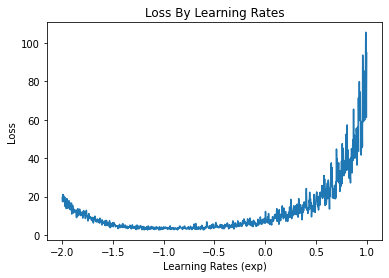

In [216]:
# PLOT LEARNING RATES TO LOSS RELATIONSHIP (Iteration One)
# Loss look best around 10^-1
import matplotlib.pyplot as plt

plt.plot(tri_learning_rates, tri_loss_values)
plt.title("Loss By Learning Rates")
plt.xlabel("Learning Rates (exp)")
plt.ylabel("Loss")
plt.show()

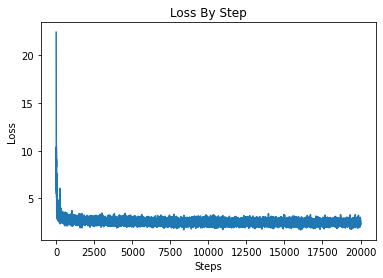

In [221]:
# PLOT STEPS TO LOSS RELATIONSHIP (Iteration Two, After Increasing Model Size)

plt.plot(tri_steps, tri_loss_values)
plt.title("Loss By Step")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

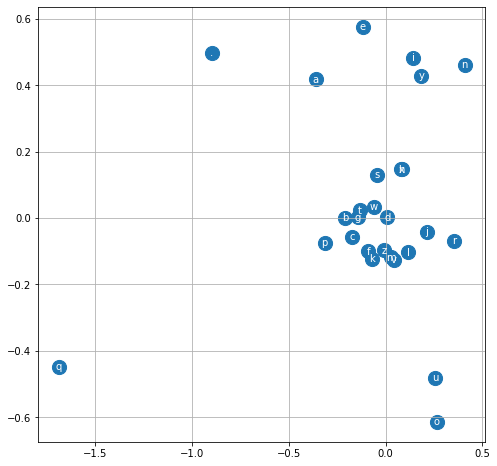

In [226]:
# PLOT EMBEDDINGS (Iteration Three)
# TODO: I don't know why this is returning embedded characters, yet.
# When characters are close to each other the neural net is treating them similarly

plt.figure(figsize=(8,8))
plt.scatter(tri_emb_lookup[:, 0].data, tri_emb_lookup[:,1].data, s=200) # each word has two dimensions / columns
for i in range(tri_emb_lookup.shape[0]):
    plt.text(tri_emb_lookup[i, 0].item(), tri_emb_lookup[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [223]:
# CHECK TOTAL LOSS ON TRAIN_SET FORWARD PASS

# Do a forward pass (without updates)
tri_xs_embeddings = tri_emb_lookup[tri_xs]
tri_hidden_layer = torch.tanh(tri_xs_embeddings.view(-1, 6) @ tri_W1 + tri_b1)
tri_logits = tri_hidden_layer @ tri_W2 + tri_b2 # matrix multiplication, give us the log counts
tri_loss = F.cross_entropy(tri_logits, tri_ys)
tri_loss


tensor(2.4441, grad_fn=<NllLossBackward0>)

In [225]:
# CHECK LOSS ON DEV_SET FORWARD PASS TO TUNE HYPERPARAMETERS

# Convert the dev_set to tensors
dev_tri_xs, dev_tri_ys = [], []
tri_block_size = 3

for w in dev_set:
    context_window = [0] * tri_block_size

    for ch in w + '.':
        index = stoi[ch]

        dev_tri_xs.append(context_window) # this is the training set for the neural network
        dev_tri_ys.append(index)
        context_window = context_window[1:] + [index]

dev_tri_xs = torch.tensor(dev_tri_xs) # convert to tensor
dev_tri_ys = torch.tensor(dev_tri_ys)

# Do a forward pass (without updates)
dev_tri_xs_embeddings = tri_emb_lookup[dev_tri_xs]
dev_tri_hidden_layer = torch.tanh(dev_tri_xs_embeddings.view(-1, 6) @ tri_W1 + tri_b1)
dev_tri_logits = dev_tri_hidden_layer @ tri_W2 + tri_b2 # matrix multiplication, give us the log counts
dev_tri_loss = F.cross_entropy(dev_tri_logits, dev_tri_ys)
dev_tri_loss

# After I run this, I can go back to the model training portion and run it again, potentially with a learning rate decay (reduce by factor of 10)
# That way I keep tuning the model and checking if training is still making a dent on the loss. 

# Iteration 1: loss went up by ~1 after running my third training run; I may be overfitting. Ideally in this case I would have implemented a checkpoint to load, but that will be in a future round
# Iteration 2: reinitialized network and decayed learning rate to 0.01. Similar loss to train_set, so we are underfitting and can improve performance with scale.
# Iteration 3: after several runs improvement has stagnated, so embedding size might now be the bottleneck.

tensor(2.4455, grad_fn=<NllLossBackward0>)